## Variational Autoencoder (VAE)
A tutorial with code for a VAE as described in [Kingma and Welling, 2013](http://arxiv.org/abs/1312.6114). A talk with more details was given at the [DataLab Brown Bag Seminar](https://home.zhaw.ch/~dueo/bbs/XXX).

Much of the code was taken, from https://jmetzen.github.io/2015-11-27/vae.html. However, I tried to focus more on the mathematical understanding, not so much on design of the algorithm.

### Some theoretical considerations 

#### Outline
Situation: $x$ is from a high-dimensional space and $z$ is from a low-dimensional (latent) space, from which we like to reconstruct $p(x)$. 

We consider a parameterized model $p_\theta(x|z)$ (with parameter $\theta$), to construct x for a given value of $z$. We build this model: 

* $p_\theta(x | z)$ with a neural network determening the parameters $\mu, \Sigma$ of a Gaussian (or as done here with a Bernoulli-Density). 

#### Inverting $p_\theta(x | z)$

The inversion is not possible, we therefore approximate $p(z|x)$ by $q_\phi (z|x)$ again a combination of a NN determening the parameters of a Gaussian

* $q_\phi(z | x)$ with a neural network + Gaussian 

#### Training

We train the network treating it as an autoencoder. 

#### Lower bound of the Log-Likelihood
The likelihood cannot be determined analytically. Therefore, in a first step we derive a lower (variational) bound $L^{v}$ of the log likelihood, for a given image. Technically we assume a discrete latent space. For a continous case simply replace the sum by the appropriate integral over the respective densities. We replace the inaccessible conditional propability $p(z|x)$ with an approximation $q(z|x)$ for which we later use a neural network topped by a Gaussian.

\begin{align}
L & = \log\left(p(x)\right) &\\
  & = \sum_z q(z|x) \; \log\left(p(x)\right) &\text{multiplied with 1 }\\
  & = \sum_z q(z|x) \; \log\left(\frac{p(z,x)}{p(z|x)}\right) &\\
  & = \sum_z q(z|x) \; \log\left(\frac{p(z,x)}{q(z|x)} \frac{q(z|x)}{p(z|x)}\right) &\\
  & = \sum_z q(z|x) \; \log\left(\frac{p(z,x)}{q(z|x)}\right) + \sum_z q(z|x) \; \log\left(\frac{q(z|x)}{p(z|x)}\right) &\\
  & = L^{\tt{v}} + D_{\tt{KL}} \left( q(z|x) || p(z|x) \right) &\\
  & \ge L^{\tt{v}} \\
\end{align}

The KL-Divergence $D_{\tt{KL}}$ is always positive, and the smaller the better $q(z|x)$ approximates $p(z|x)$


### Rewritting  $L^\tt{v}$
We split $L^\tt{v}$ into two parts.

\begin{align}
L^{\tt{v}} & = \sum_z q(z|x) \; \log\left(\frac{p(z,x)}{q(z|x)}\right)  & \text{with} \;\;p(z,x) = p(x|z) \,p(z)\\
  & =  \sum_z q(z|x) \; \log\left(\frac{p(x|z) p(z)}{q(z|x)}\right)  &\\
  & =  \sum_z q(z|x) \; \log\left(\frac{p(z)}{q(z|x)}\right)  + \sum_z q(z|x) \; \log\left(p(x|z)\right) &\\
  & =  -D_{\tt{KL}} \left( q(z|x) || p(z) \right)  +  \mathbb{E}_{q(z|x)}\left( \log\left(p(x|z)\right)\right) &\text{putting in } x^{(i)} \text{ for } x\\
  & =  -D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)  +  \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) &\\
\end{align}

Approximating $\mathbb{E}_{q(z|x^{(i)})}$ with sampling form the distribution $q(z|x^{(i)})$

#### Sampling 
With $z^{(i,l)}$ $l = 1,2,\ldots L$ sampled from $z^{(i,l)} \thicksim q(z|x^{(i)})$
\begin{align}
L^{\tt{v}} & = -D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)  
+  \mathbb{E}_{q(z|x^{(i)})}\left( \log\left(p(x^{(i)}|z)\right)\right) &\\
L^{\tt{v}} & \approx -D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)  
+  \frac{1}{L} \sum_{i=1}^L \log\left(p(x^{(i)}|z^{(i,l)})\right) &\\
\end{align}

#### Calculation of $D_{\tt{KL}} \left( q(z|x^{(i)}) || p(z) \right)$
TODO

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
ver = tf.__version__
print("Tensor Flow version {}".format(ver))

Tensor Flow version 0.7.1


##### Loading the MNIST images 
Note that the images have the dimension (batch_size x 784) and we do not take the local structure of the images into account

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Number of samples 55000 Shape of y[(55000, 10)] Shape of X[(55000, 784)]


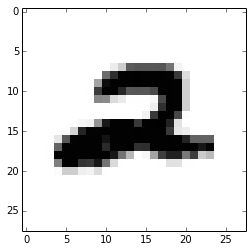

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
n_samples = mnist.train.num_examples
print("Number of samples {} Shape of y[{}] Shape of X[{}]"
      .format(n_samples, mnist.train.labels.shape, mnist.train.images.shape))
plt.imshow(np.reshape(-mnist.train.images[4242], (28, 28)), interpolation='none',cmap=plt.get_cmap('gray'))

In [4]:
def weights(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

### Building the networks
#### The Decoder Network

The decoder network takes the input image and calculates the mean and the log variance of the Gaussian, producing the latent variable z.

In [5]:
n_z = 2 #Dimension of the latent space
# Input
x = tf.placeholder("float", shape=[None, 28*28]) #Batchsize x Number of Pixels
y_ = tf.placeholder("float", shape=[None, 10])   #Batchsize x 10 (one hot encoded)

# First hidden layer
W_fc1 = weights([784, 500])
b_fc1 = bias([500])
h_1   = tf.nn.softplus(tf.matmul(x, W_fc1) + b_fc1)

# Second hidden layer 
W_fc2 = weights([500, 501]) #501 and not 500 to spot errors
b_fc2 = bias([501])
h_2   = tf.nn.softplus(tf.matmul(h_1, W_fc2) + b_fc2)

# Parameters for the Gaussian
z_mean = tf.add(tf.matmul(h_2, weights([501, n_z])), bias([n_z]))
z_log_sigma_sq = tf.add(tf.matmul(h_2, weights([501, n_z])), bias([n_z]))

#### The Encoder Network

Samples from a Gaussian using the given mean and the std. The sampling is done by addding a random number ensuring that backpropagation works fine.

In [6]:
batch_size = 64
eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32) # Adding a random number
z = tf.add(z_mean, tf.mul(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))  # The sampled z

In [7]:
W_fc1_g = weights([n_z, 500])
b_fc1_g = bias([500])
h_1_g   = tf.nn.softplus(tf.matmul(z, W_fc1_g) + b_fc1_g)

W_fc2_g = weights([500, 501])
b_fc2_g = bias([501])
h_2_g   = tf.nn.softplus(tf.matmul(h_1_g, W_fc2_g) + b_fc2_g)

x_reconstr_mean = tf.nn.sigmoid(tf.add(tf.matmul(h_2_g,  weights([501, 784])), bias([784])))

#### Defining the loss function

In [8]:
reconstr_loss = -tf.reduce_sum(x * tf.log(1e-10 + x_reconstr_mean) + (1-x) * tf.log(1e-10 + 1 - x_reconstr_mean), 1)
latent_loss = -0.5 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)
cost = tf.reduce_mean(reconstr_loss + latent_loss)   # average over batch

# Use ADAM optimizer
optimizer =  tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

### Training the network

In [10]:
runs = 0 #Set to 0, for no training
init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    batch_xs, _ = mnist.train.next_batch(batch_size)
    dd = sess.run([cost], feed_dict={x: batch_xs})
    print('Test run after starting {}'.format(dd))

    for epoch in range(runs):
        avg_cost = 0.
        total_batch = int(n_samples / batch_size)
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, _ = mnist.train.next_batch(batch_size)
            _,d = sess.run((optimizer, cost), feed_dict={x: batch_xs})
            avg_cost += d / n_samples * batch_size

        # Display logs per epoch step
        if epoch % 1 == 0:
            save_path = saver.save(sess, "model/model.ckpt") #Saves the weights (not the graph)
            print("Model saved in file: {}".format(save_path))
            print "Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost)

Test run after starting [1057.4442]


Model restored.


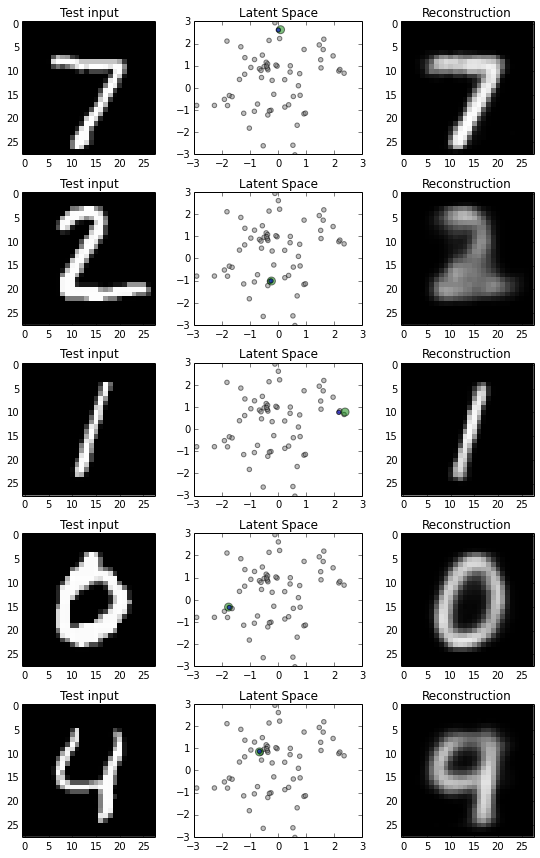

In [11]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model/model.ckpt")
    print("Model restored.")
    x_sample = mnist.test.next_batch(64)[0]
    x_reconstruct,z_vals,z_mean_val,z_log_sigma_sq_val  = sess.run((x_reconstr_mean,z, z_mean, z_log_sigma_sq), feed_dict={x: x_sample})

    plt.figure(figsize=(8, 12))
    for i in range(5):
        plt.subplot(5, 3, 3*i + 1)
        plt.imshow(x_sample[i].reshape(28, 28), vmin=0, vmax=1,  interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Test input")
        
        #plt.colorbar()
        plt.subplot(5, 3, 3*i + 2)
        plt.scatter(z_vals[:,0],z_vals[:,1], c='gray', alpha=0.5)
        plt.scatter(z_mean_val[i,0],z_mean_val[i,1], c='green', s=64, alpha=0.5)
        plt.scatter(z_vals[i,0],z_vals[i,1], c='blue', s=16, alpha=0.5)
       
        plt.xlim((-3,3))
        plt.ylim((-3,3))
        plt.title("Latent Space")
        
        plt.subplot(5, 3, 3*i + 3)
        plt.imshow(x_reconstruct[i].reshape(28, 28), vmin=0, vmax=1, interpolation='none',cmap=plt.get_cmap('gray'))
        plt.title("Reconstruction")
        #plt.colorbar()
    plt.tight_layout()
    
    

In [14]:
np.mean(np.sqrt(np.exp(z_log_sigma_sq_val))) #Usually the choosen sigma is quite small

0.047850069

Model restored.


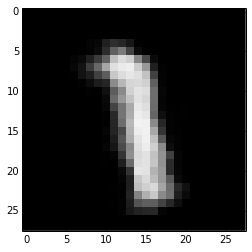

In [15]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model/model.ckpt")
    print("Model restored.")
    d = np.zeros([batch_size,2],dtype='float32')
    d[0,] = [1,2]
    x_reconstruct = sess.run(x_reconstr_mean, feed_dict={z: d})
    plt.imshow(x_reconstruct[0].reshape(28, 28), vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))

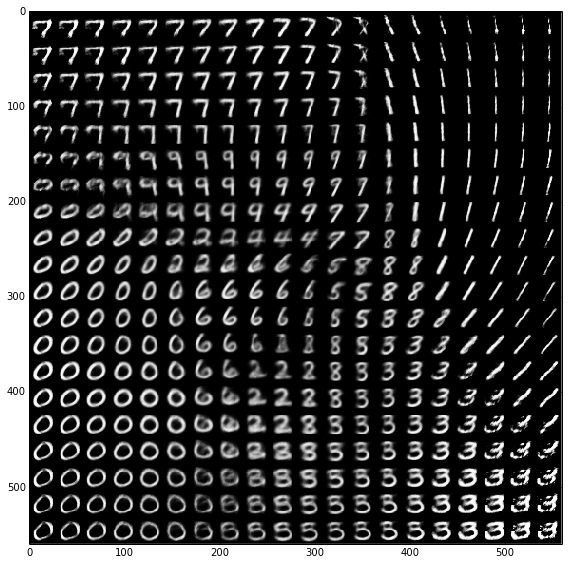

In [17]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)
canvas = np.empty((28*ny, 28*nx))
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "model/model.ckpt")
    for i, yi in enumerate(x_values):
        for j, xi in enumerate(y_values):
            z_mu = np.array([[xi, yi]])
            d[0] = z_mu
            x_mean = sess.run(x_reconstr_mean, feed_dict={z: d})
            canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", vmin=0, vmax=1,interpolation='none',cmap=plt.get_cmap('gray'))
plt.tight_layout()

### The latent distribution p(z|x) of the training set

In [18]:
saver = tf.train.Saver()
all_z = np.zeros((1,2))
with tf.Session() as sess:
    saver.restore(sess, "model/model.ckpt")
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        x_reconstruct,z_vals,z_mean_val,z_log_sigma_sq_val  = \
        sess.run((x_reconstr_mean,z, z_mean, z_log_sigma_sq), feed_dict={x: batch_xs})
        all_z = np.vstack((all_z, z_mean_val))
            

<matplotlib.colorbar.Colorbar instance at 0x10b0dd1b8>

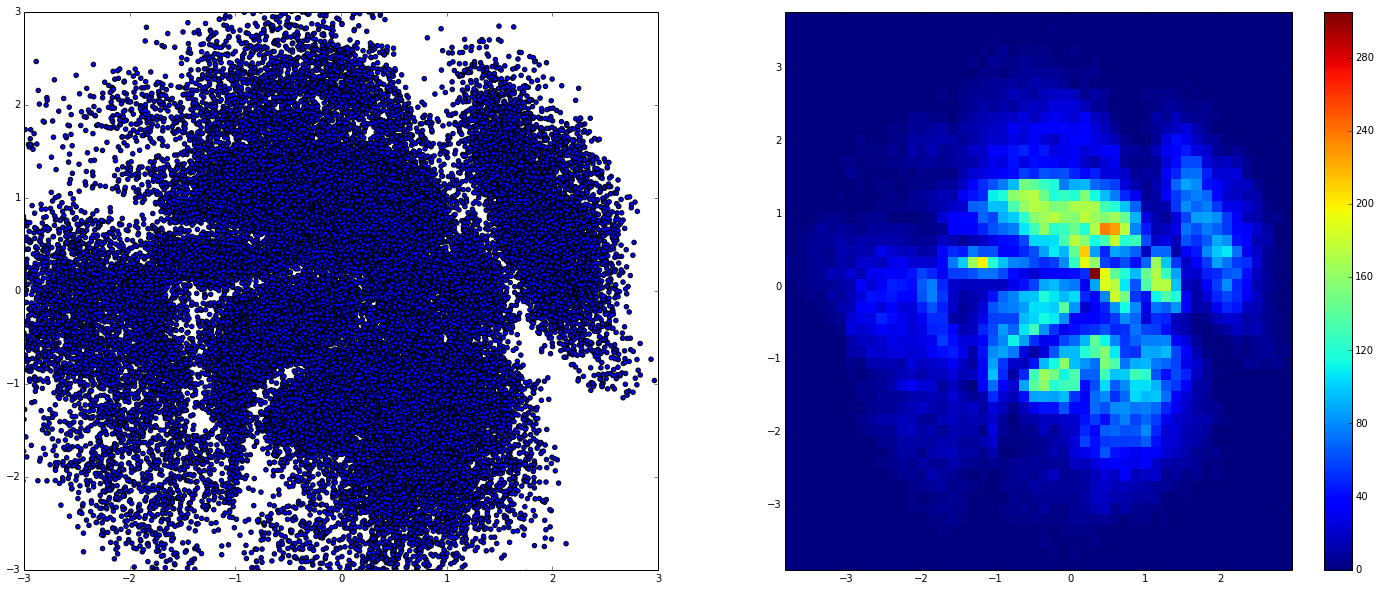

In [19]:
plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
plt.scatter(all_z[:,0], all_z[:,1])
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.subplot(1,2,2)
plt.hist2d(all_z[:,0], all_z[:,1], (50, 50), cmap=plt.cm.jet)
plt.colorbar()